# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

Prep Output Directory

In [56]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/CALVIN_FANCY_ANALYSIS/figures'

Import Data

In [57]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/CALVIN_FANCY_ANALYSIS/data.csv'
sheet = None

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
display(data_df)

# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [59]:
drop_list = ['GOSEbin','impact_lab_prob']


In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [ ]:
data_df.columns

Set the parameters for dropping rows

In [7]:
column = 'Cohort'  # The column you'd like to evaluate
condition = 'equal'  # The condition to check ('equal', 'above', 'below', 'not')
value = 0 # The value to drop if found

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['DX_M12'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']


In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

# 01 - Generate Formulas to Test

In [ ]:
data_df.columns

In [ ]:
## this code is specifically to whittle down sam's massive amount of data. 

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data_df is your dataframe
# Ensure 'GOSEbin' is present in the dataframe
if 'GOSEbin' not in data_df.columns:
    raise KeyError("GOSEbin not found in dataframe columns.")

# Calculate Spearman correlation for each variable with 'GOSEbin'
correlations = []
for column in data_df.columns:
    if column != 'GOSEbin':
        # Calculate Spearman correlation
        rho, _ = stats.spearmanr(data_df[column], data_df['GOSEbin'])
        correlations.append((column, rho))

# Convert to DataFrame for plotting
correlation_df = pd.DataFrame(correlations, columns=['Variable', 'Spearman_Rho'])

# Plot the correlations using barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Variable', y='Spearman_Rho', data=correlation_df, palette='viridis')
plt.xticks(rotation=90)
plt.title('Spearman Correlation of Each Variable with GOSEbin')
plt.ylabel('Spearman Rho')
plt.xlabel('Variables')
plt.show()

import pandas as pd
import scipy.stats as stats

# Assuming data_df is your dataframe
# Ensure 'GOSEbin' is present in the dataframe
if 'GOSEbin' not in data_df.columns:
    raise KeyError("GOSEbin not found in dataframe columns.")

# Calculate Spearman correlation for each variable with 'GOSEbin'
significant_columns = []
for column in data_df.columns:
    if column != 'GOSEbin':
        # Calculate Spearman correlation
        rho, _ = stats.spearmanr(data_df[column], data_df['GOSEbin'])
        # Check if absolute value of rho is greater than 0.15
        if abs(rho) > 0.15:
            significant_columns.append(column)

# Return the list of significant columns
len(significant_columns)

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
data_df['GOSEbin'] = pd.to_numeric(data_df['GOSEbin'], errors='coerce')

# Step 1: Regress impact_lab_prob out of GOSEbin
X = sm.add_constant(data_df['impact_lab_prob'])
model = sm.OLS(data_df['GOSEbin'], X).fit()
residuals = model.resid

# Step 2: Calculate Spearman correlation for each variable with the residuals
significant_columns_after = []
for column in data_df.columns:
    if column not in ['GOSEbin', 'impact_lab_prob']:
        rho, _ = stats.spearmanr(data_df[column], residuals)
        if abs(rho) > 0.15:
            significant_columns_after.append(column)

# Step 3: Calculate the intersection with original significant columns

# Intersection of new significant columns with old ones
new_significant_columns = list(set(significant_columns_after) - set(significant_columns))

# Display new columns that popped out
new_significant_columns
import matplotlib.pyplot as plt
import seaborn as sns
# Step 4: Calculate the Spearman correlation values for the new significant columns
correlation_values = {}
for column in new_significant_columns:
    rho, _ = stats.spearmanr(data_df[column], residuals)
    correlation_values[column] = rho

# Convert the correlation values to a dataframe for easy plotting
correlation_df = pd.DataFrame.from_dict(correlation_values, orient='index', columns=['Spearman Correlation'])

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_df.index, y='Spearman Correlation', data=correlation_df)
plt.xticks(rotation=45, ha='right')
plt.title('Spearman Correlation of New Significant Columns with GOSEbin Residuals')
plt.ylabel('Spearman Correlation')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()



In [63]:
dep_var = 'GOSEbin'
indep_var_list = new_significant_columns + significant_columns

Generate all possible regressions

In [ ]:
from calvin_utils.ml_utils.graph_feature_selector.loocv import FormulaGenerator
formulae = FormulaGenerator.generate_all_formulas(predictors=indep_var_list, dep_var=dep_var, max_predictors_in_model=2, max_interaction_level=2)

In [ ]:
len(formulae)

Evaluate the Formulae

In [ ]:
from calvin_utils.ml_utils.graph_feature_selector.loocv_manager import LOOCVManager
performance_df = LOOCVManager(data_df, formulae, model_type='binomial_logit').run_all(multiprocess=False)
performance_df

Save your hard-fought data if you'd like. 

In [124]:
performance_df.to_csv('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/CALVIN_FANCY_ANALYSIS/computed_results_2lvl.csv')
import pandas as pd
# performance_df = pd.read_csv('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/CALVIN_FANCY_ANALYSIS/computed_results_2lvl.csv')

Now get their p-values

In [ ]:
from calvin_utils.ml_utils.graph_feature_selector.loocv_perm import LOOCVPermutationTester
performance_df = LOOCVPermutationTester(data_df=data_df, results_df=performance_df, 
                           model_type='binomial_logit', num_permutations=100, 
                           multiprocess=True, max_workers=None).run()
performance_df

Save your hard-fought data if you'd like. 

In [28]:
import pandas as pd
performance_df = pd.read_csv('/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/CALVIN_FANCY_ANALYSIS/computed_results_p.csv')

Remove non-significant clusters

In [ ]:
performance_df

In [ ]:
performance_df = performance_df[performance_df['Entropy'] < 0.70]
display(performance_df)

# 02 - Cluster Out Highly Performing Models

In [126]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

class PerformanceClusterer:
    def __init__(self, performance_df, num_clusters=5):
        """
        Initializes the PerformanceClusterer with performance data and clustering parameters.

        Parameters:
        -----------
        performance_df : pd.DataFrame
            DataFrame containing columns: R2, RMSE, Entropy, Average_AIC, Formula, p-value.
        num_clusters : int, optional, default=5
            The number of clusters to form.
        """
        self.original_df = performance_df.copy()
        self.num_clusters = num_clusters
        self.clustered_df = None  # To store the DataFrame with cluster labels
        self._prepare_data()
        self._perform_clustering()
    
    def _prepare_data(self):
        """
        Prepares the data for clustering by selecting relevant features and handling NaNs.
        """
        # Select relevant columns: choose Entropy if available; otherwise, RMSE
        self.original_df['Metric'] = self.original_df.apply(
            lambda row: row['Entropy'] if pd.notna(row['Entropy']) else row['RMSE'], axis=1
        )
        
        # Select features: R2, Metric, Average_AIC
        if self.original_df['RMSE'].notna().sum() != 0:
            self.features = self.original_df[['R2', 'RMSE', 'Average_AIC']].copy()
        else:
            self.features = self.original_df[['R2', 'Entropy', 'Average_AIC']].copy()
        
        # Drop rows with any NaNs in the selected features
        self.features = self.features.dropna()
        self.clustered_df = self.original_df.loc[self.features.index].reset_index(drop=True)
        self.features = self.features.reset_index(drop=True)
        
        # Standardize the features
        self.scaled_features = StandardScaler().fit_transform(self.features)
    
    def _perform_clustering(self):
        """
        Applies Agglomerative Clustering to the standardized features and assigns cluster labels.
        """
        clustering = AgglomerativeClustering(n_clusters=self.num_clusters, affinity='euclidean', linkage='ward')
        self.clustered_df['Cluster'] = clustering.fit_predict(self.scaled_features)
    
    def get_clustered_data(self):
        """
        Returns the clustered DataFrame with an added 'cluster' column.

        Returns:
        --------
        pd.DataFrame
            DataFrame containing original performance metrics along with cluster labels.
        """
        return self.clustered_df.copy()

In [ ]:
performance_df = PerformanceClusterer(performance_df=performance_df, num_clusters=3).get_clustered_data()

Extract Number of Interactions in Each Formula

```

        def count_predictors(formula):
            right_side = formula.split("~")[1].strip()

            # Check for both '*' and '+' in the formula
            if '*' in right_side and '+' in right_side:
                terms = []
                for term in right_side.split('+'):
                    terms.extend(term.split('*'))
                return len(terms)

            # Check for '*' in the formula
            elif '*' in right_side:
                return len(right_side.split('*'))

            # Check for '+' in the formula
            elif '+' in right_side:
                return len(right_side.split('+'))

            # If neither exists, it means there's only one predictor
            else:
                return 1
                ```

In [128]:
import re
import pandas as pd

class InteractionCounter:
    def __init__(self, df):
        self.df = df

    def count_interactions(self, formula):
        """
        Counts the number of variables involved in the interaction term.

        Parameters:
        -----------
        formula : str
            The formula string to parse.

        Returns:
        --------
        int
            Number of variables in the formula.
        """
        # Remove whitespace and split the formula by '*'
        variables = re.split(r'\*', formula.replace(' ', ''))
        # Clean up variable names by removing any non-alphanumeric characters
        variables = [re.sub(r'[^a-zA-Z0-9_]', '', var) for var in variables]
        # Return the number of unique variables
        return len(set(variables))

    def apply_interaction_count(self):
        """
        Applies the count_interactions method to the 'Formula' column in the DataFrame
        and creates a new column 'Interaction_Level' with the count of variables.
        """
        self.df['Interaction_Level'] = self.df['Formula'].apply(self.count_interactions)
        return self.df

In [ ]:
counter = InteractionCounter(performance_df)
performance_df = counter.apply_interaction_count()
performance_df

In [ ]:
performance_df.Interaction_Level.unique()

# 03 - Visualize Clusters

In [142]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re

class PerformancePlotter:
    def __init__(self, clustered_df):
        """
        Initializes the PerformancePlotter with clustered performance data.

        Parameters:
        -----------
        clustered_df : pd.DataFrame
            DataFrame containing columns: R2, RMSE, Entropy, Average_AIC, Formula, p-value, cluster.
        """
        self.df = clustered_df.copy()
     
    def _get_significant_points(self):
        if 'p-value' in self.df.columns:
            self.df['significant'] = self.df['p-value'] < 0.05
            significant_points = self.df[self.df['significant']]
            non_significant_points = self.df[~self.df['significant']]
        else:
            significant_points = None
            non_significant_points = self.df
        return significant_points, non_significant_points

    def create_hover_text(self, df):
        """
        Creates custom hover text for each data point.

        Parameters:
        -----------
        df : pd.DataFrame
            The DataFrame slice for which to create hover text.

        Returns:
        --------
        list
            A list of hover text strings.
        """
        hover_text = []
        for index, row in df.iterrows():
            texts = [
                f"Formula: {row['Formula']}",
                f"R²: {row['R2']:.2f}",
                f"Entropy/RMSE: {row['Entropy'] if 'Entropy' in row else row['RMSE']}",
                f"Average AIC: {row['Average_AIC']}",
                f"Cluster: {row['Cluster']}"
            ]
            if 'p-value' in df.columns:
                texts["p-value"] = row['p-value']
            hover_text.append('<br>'.join(texts))
        return hover_text

    def visualize_3D_scatter(self):
        # Create symbol mapping for Interaction_Level
        symbol_sequence = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'star', 'hexagram']
        interaction_levels = sorted(self.df['Interaction_Level'].unique())
        symbol_map = {level: symbol_sequence[(level - 1) % len(symbol_sequence)] for level in interaction_levels}
        self.df['symbol'] = self.df['Interaction_Level'].map(symbol_map)

        significant_points, non_significant_points = self._get_significant_points()
        marker_size = 10

        # Initialize the figure
        fig = go.Figure()
        # Add non-significant points
        hover_text_non_sig = self.create_hover_text(non_significant_points)
        fig.add_trace(
            go.Scatter3d(
                x=non_significant_points['R2'],
                y=non_significant_points['Entropy'] if 'Entropy' in self.df.columns else non_significant_points['RMSE'],
                z=non_significant_points['Average_AIC'],
                mode='markers',
                marker=dict(
                    symbol=non_significant_points['symbol'],
                    size=5,
                    color=non_significant_points['Cluster'],
                    colorscale='Viridis',
                    line=dict(width=0),
                    opacity=0.6
                ),
                text=hover_text_non_sig,
                hoverinfo='text'
            )
        )
        if significant_points is not None:
            # Add significant points with outline
            hover_text_sig = self.create_hover_text(significant_points)
            fig.add_trace(
                go.Scatter3d(
                    x=significant_points['R2'],
                    y=significant_points['Entropy'] if 'Entropy' in self.df.columns else significant_points['RMSE'],
                    z=significant_points['Average_AIC'],
                    mode='markers',
                    marker=dict(
                        symbol=significant_points['symbol'],
                        size=significant_points['marker_size'],
                        color=significant_points['Cluster'],
                        colorscale='Viridis',
                        line=dict(width=50, color='black'),
                        opacity=1.0
                    ),
                    text=hover_text_sig,
                    hoverinfo='text'
                )
            )

        # Update layout
        fig.update_layout(
            title="3D Scatter Plot of Model Performance Metrics with Interaction Levels and Significance",
            scene=dict(
                xaxis=dict(title='R²'),
                yaxis=dict(title='Entropy' if 'Entropy' in self.df.columns else 'RMSE'),
                zaxis=dict(title='Average AIC')
            ),
            legend_title_text='Cluster',
            height=800
        )

        fig.show()
        return fig 
    
    
    def save_plotly_figure_as_html(self, fig, filename='3D_scatter_plot.html'):
        """
        Save a Plotly figure as an HTML file.

        Parameters:
        - fig: Plotly figure object to be saved.
        - filename: Name of the HTML file to save the figure. Default is '3D_scatter_plot.html'.
        """
        fig.write_html(filename)


    def get_plot_data(self):
        """
        Returns the DataFrame prepared for plotting.

        Returns:
        --------
        pd.DataFrame
            DataFrame containing performance metrics, cluster labels, and plotting attributes.
        """
        return self.df.copy()


In [ ]:
plotter = PerformancePlotter(performance_df)
fig = plotter.visualize_3D_scatter()
plotter.save_plotly_figure_as_html(fig, filename=out_dir+'/p_under_05_models.html')

# 05 - Identify the Highly Performing Predictors
- Rank predictors based on their overall impact on each regression.

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re

class PredictorPerformanceAnalyzer:
    def __init__(self, df):
        """
        Initializes the analyzer with the performance DataFrame.

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing model performance metrics and formulas.
            Expected columns: 'R2', 'RMSE', 'Entropy', 'Average_AIC', 'Formula'
        """
        self.df = df.copy()
        self.predictor_metrics_df = None
        self.aggregated_df = None
        self.standardized_df = None
        self.ranked_df = None
        self.metric_name = None  # Will be set based on available metric ('RMSE' or 'Entropy')

    def extract_predictors_from_formula(self, formula):
        """
        Extracts predictors from a regression formula string.
        """
        # Remove the response variable
        rhs = formula.split('~')[1]
        rhs = re.sub(r'[\+\*]', ',', rhs)
        predictors = [pred.strip() for pred in rhs.split(',')]
        # Remove empty strings and duplicates
        predictors = list(set(filter(None, predictors)))
        return predictors

    def associate_predictors_with_metrics(self):
        """
        Associates each predictor with the performance metrics from its models.
        """
        predictor_metrics = []

        # Determine which metric to use: RMSE or Entropy
        if self.df['Entropy'].notna().any():
            self.metric_name = 'Entropy'
        elif self.df['RMSE'].notna().any():
            self.metric_name = 'RMSE'
        else:
            raise ValueError("Neither 'RMSE' nor 'Entropy' metrics are available in the DataFrame.")

        # Iterate over each model (row in the DataFrame)
        for _, row in self.df.iterrows():
            formula = row['Formula']
            predictors = self.extract_predictors_from_formula(formula)

            # Use RMSE or Entropy based on which is not NaN
            metric_value = row[self.metric_name]
            if pd.isna(metric_value):
                continue  # Skip if the metric is NaN

            metrics = {
                'R2': row['R2'],
                self.metric_name: metric_value,
                'Average_AIC': row['Average_AIC']
            }

            for predictor in predictors:
                predictor_metrics.append({
                    'Predictor': predictor,
                    'R2': metrics['R2'],
                    self.metric_name: metrics[self.metric_name],
                    'Average_AIC': metrics['Average_AIC']
                })

        # Create DataFrame from the list
        self.predictor_metrics_df = pd.DataFrame(predictor_metrics)

    def compute_aggregated_metrics(self):
        """
        Computes mean performance metrics per predictor.
        """
        if self.predictor_metrics_df is None:
            raise ValueError("Please run 'associate_predictors_with_metrics' method first.")

        aggregated_df = self.predictor_metrics_df.groupby('Predictor').agg({
            'R2': 'mean',
            self.metric_name: 'mean',
            'Average_AIC': 'mean',
            'R2': 'count'  # Number of models the predictor appears in
        }).rename(columns={'R2': 'R2_mean', self.metric_name: f'{self.metric_name}_mean', 'Average_AIC': 'Average_AIC_mean', 'count': 'Model_Count'}).reset_index()

        self.aggregated_df = aggregated_df

    def standardize_metrics(self):
        """
        Standardizes the performance metrics.
        """
        if self.aggregated_df is None:
            raise ValueError("Please run 'compute_aggregated_metrics' method first.")

        metrics_to_standardize = ['R2_mean', f'{self.metric_name}_mean', 'Average_AIC_mean']
        scaler = StandardScaler()
        standardized_values = scaler.fit_transform(self.aggregated_df[metrics_to_standardize])
        self.aggregated_df[['z_R2_mean', f'z_{self.metric_name}_mean', 'z_Average_AIC_mean']] = standardized_values

    def compute_composite_score(self):
        """
        Computes a composite score for each predictor.
        """
        if self.aggregated_df is None:
            raise ValueError("Please run 'standardize_metrics' method first.")

        # Higher R2 is better (+), lower Entropy/RMSE and AIC are better (-)
        self.aggregated_df['Composite_Score'] = (
            self.aggregated_df['z_R2_mean'] - 
            self.aggregated_df[f'z_{self.metric_name}_mean'] - 
            self.aggregated_df['z_Average_AIC_mean']
        )

    def rank_predictors(self):
        """
        Ranks predictors based on the composite score.
        """
        if 'Composite_Score' not in self.aggregated_df.columns:
            raise ValueError("Please run 'compute_composite_score' method first.")

        self.ranked_df = self.aggregated_df.sort_values(by='Composite_Score', ascending=False).reset_index(drop=True)

    def visualize_predictor_composite_scores(self):
        """
        Generates a bar plot for predictors' composite scores.
        """
        if self.ranked_df is None:
            raise ValueError("Please run 'rank_predictors' method first.")

        plt.figure(figsize=(10, 6))
        sns.barplot(data=self.ranked_df, x='Composite_Score', y='Predictor', orient='h', palette='viridis')
        plt.title('Predictor Ranking Based on Composite Score')
        plt.xlabel('Composite Score')
        plt.ylabel('Predictor')
        plt.tight_layout()
        plt.show()
        
    def run(self):
        # Initialize the analyzer
        self.associate_predictors_with_metrics()
        self.compute_aggregated_metrics()
        self.standardize_metrics()
        self.compute_composite_score()
        self.rank_predictors()
        self.visualize_predictor_composite_scores()

In [ ]:
# Initialize the analyzer
analyzer = PredictorPerformanceAnalyzer(performance_df)
analyzer.run()

# 06 - Graph the Relationships within Clusters

Extract Performance of Each Predictor and Each Interaction within clusters

In [224]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class ClassInteractionAnalyzer:
    def __init__(self, performance_df, predictor_to_class_dict):
        """
        Initializes the ClassInteractionAnalyzer with the performance DataFrame
        and the predictor-to-class mapping dictionary.

        Parameters:
        -----------
        performance_df : pd.DataFrame
            DataFrame containing model performance metrics and formulas.
        predictor_to_class_dict : dict
            Dictionary mapping predictors to their corresponding classes.
        """
        self.performance_df = performance_df.copy()
        self.predictor_to_class_dict = predictor_to_class_dict
        self.cluster_labels = self.performance_df['Cluster'].unique()
        self.class_scores = {}
        self.class_frequencies = {}
        self.class_interaction_scores = {}
        self.class_interaction_frequencies = {}

    def calculate_composite_scores(self):
        """
        Calculates the composite score for each formula based on performance metrics.
        """
        metrics = ['R2', 'Entropy', 'Average_AIC']
        available_metrics = [metric for metric in metrics if metric in self.performance_df.columns]

        scaler = StandardScaler()
        standardized_metrics = scaler.fit_transform(self.performance_df[available_metrics])

        standardized_df = pd.DataFrame(standardized_metrics, columns=[f'z_{metric}' for metric in available_metrics])

        # Assuming higher R2 is better, lower Entropy and AIC are better
        standardized_df['Composite_Score'] = (
            standardized_df.get('z_R2', 0) -
            standardized_df.get('z_Entropy', 0) -
            standardized_df.get('z_Average_AIC', 0)
        )

        self.performance_df.reset_index(drop=True, inplace=True)
        self.performance_df['Composite_Score'] = standardized_df['Composite_Score']
    
    def map_predictors_to_classes(self, predictors):
        """
        Maps predictors to their corresponding classes.

        Parameters:
        -----------
        predictors : iterable of str
            Predictors to map.

        Returns:
        --------
        predictor_classes : dict
            Dictionary mapping predictors to classes.
        """
        return {predictor: self.predictor_to_class_dict.get(predictor, 'Unknown') for predictor in predictors}
    
    def calculate_class_scores(self, predictor_scores, predictor_classes):
        """
        Calculates average composite scores for each class.

        Parameters:
        -----------
        predictor_scores : dict
            Dictionary mapping predictors to composite scores.
        predictor_classes : dict
            Dictionary mapping predictors to classes.

        Returns:
        --------
        class_average_scores : dict
            Dictionary mapping classes to average composite scores.
        """
        class_scores = {}
        for predictor, scores in predictor_scores.items():
            cls = predictor_classes[predictor]
            if cls not in class_scores: # init
                class_scores[cls] = []
            class_scores[cls].extend(scores) # store the score associated w/ class

        class_average_scores = {cls: np.mean(scores) for cls, scores in class_scores.items()} # average scores associated w/ each class
        return class_average_scores

    def calculate_class_interaction_scores(self, interaction_scores, predictor_classes):
        """
        Calculates average composite scores for each class-class interaction.

        Parameters:
        -----------
        interaction_scores : dict
            Dictionary mapping predictor tuples to composite scores.
        predictor_classes : dict
            Dictionary mapping predictors to classes.

        Returns:
        --------
        class_interaction_average_scores : dict
            Dictionary mapping class pairs to average composite scores.
        """
        class_interaction_scores = {}
        for predictors_tuple, scores in interaction_scores.items():
            classes_involved = [predictor_classes.get(pred, 'Unknown') for pred in predictors_tuple] #a list of the classes in the interaction tuple
            classes_tuple = tuple(sorted(set(classes_involved))) #a de-duplicated tuple of the classes in the interaction. Sorted for matching purposes.
            if len(classes_tuple) < 2: 
                continue
            if classes_tuple not in class_interaction_scores:
                class_interaction_scores[classes_tuple] = [] # init
            class_interaction_scores[classes_tuple].extend(scores) # store the composite score of the interaction

        class_interaction_average_scores = {cls_pair: np.mean(scores) for cls_pair, scores in class_interaction_scores.items()} #gen a dict of (interaction tuple): average score
        return class_interaction_average_scores
    
    def calculate_class_frequencies(self, predictor_scores, predictor_classes):
        """
        Calculates the normalized frequency of each class based on predictor_scores and predictor_classes.

        Parameters:
        -----------
        predictor_scores : dict
            Dictionary mapping predictors to lists of composite scores.
            Example: {'Predictor1': [0.5, 0.6], 'Predictor2': [0.7]}
        predictor_classes : dict
            Dictionary mapping predictors to their corresponding classes.
            Example: {'Predictor1': 'ClassA', 'Predictor2': 'ClassB'}

        Returns:
        --------
        class_frequencies : dict
            Dictionary mapping classes to normalized frequencies.
            Example: {'ClassA': 0.66, 'ClassB': 0.33}
        """
        # Count the frequency of each predictor
        predictor_frequencies = {predictor: len(scores) for predictor, scores in predictor_scores.items()}
        
        # Aggregate frequencies for each class
        class_frequency_counts = {}
        for predictor, frequency in predictor_frequencies.items():
            cls = predictor_classes.get(predictor, 'Unknown')
            class_frequency_counts[cls] = class_frequency_counts.get(cls, 0) + frequency
        
        # Normalize the frequencies
        total_frequency = sum(class_frequency_counts.values())
        class_frequencies = {cls: count / total_frequency for cls, count in class_frequency_counts.items()}
        
        return class_frequencies

    def calculate_class_interaction_frequencies(self, interaction_scores, predictor_classes):
        """
        Calculates the normalized frequency of each class interaction based on interaction_scores and predictor_classes.

        Parameters:
        -----------
        interaction_scores : dict
            Dictionary mapping tuples of predictors to lists of composite scores.
            Example: {('Predictor1', 'Predictor2'): [0.6], ('Predictor2', 'Predictor3'): [0.7, 0.8]}
        predictor_classes : dict
            Dictionary mapping predictors to their corresponding classes.
            Example: {'Predictor1': 'ClassA', 'Predictor2': 'ClassB', 'Predictor3': 'ClassC'}

        Returns:
        --------
        class_interaction_frequencies : dict
            Dictionary mapping tuples of classes to normalized frequencies.
            Example: {('ClassA', 'ClassB'): 0.5, ('ClassB', 'ClassC'): 0.5}
        """
        # Count the frequency of each interaction
        interaction_frequencies = {predictors_tuple: len(scores) for predictors_tuple, scores in interaction_scores.items()}
        
        # Map predictor interactions to class interactions and aggregate frequencies
        class_interaction_counts = {}
        for predictors_tuple, frequency in interaction_frequencies.items():
            classes_involved = [predictor_classes.get(pred, 'Unknown') for pred in predictors_tuple]
            classes_tuple = tuple(sorted(set(classes_involved)))
            if len(classes_tuple) < 2: 
                continue
            class_interaction_counts[classes_tuple] = class_interaction_counts.get(classes_tuple, 0) + frequency
        
        # Normalize the frequencies
        total_frequency = sum(class_interaction_counts.values())
        class_interaction_frequencies = {cls_tuple: count / total_frequency for cls_tuple, count in class_interaction_counts.items()}
        
        return class_interaction_frequencies
    
    def extract_terms(self, formula):
        """
        Extracts main effects and interaction terms from a formula.

        Parameters:
        -----------
        formula : str
            The regression formula.

        Returns:
        --------
        main_effects : list of str
            List of main effect predictors.
        interaction_terms : list of tuple
            List of tuples representing interaction terms.
        """
        lhs, rhs = formula.split('~')
        terms = [term.strip() for term in rhs.strip().split('+')]

        main_effects = []
        interaction_terms = []

        for term in terms:
            if '*' in term or ':' in term:
                term = term.replace(':', '*')
                predictors = [p.strip() for p in term.split('*')]
                predictors_tuple = tuple(sorted(predictors))
                interaction_terms.append(predictors_tuple)
            else:
                main_effects.append(term.strip())

        return main_effects, interaction_terms
    
    def extract_predictors_and_interactions(self, df):
        predictor_scores = {}
        interaction_scores = {}

        for _, row in df.iterrows():
            formula = row['Formula']
            composite_score = row['Composite_Score']

            main_effects, interaction_terms = self.extract_terms(formula)

            # Process main effects
            for predictor in main_effects:
                if predictor not in predictor_scores: # init the predictor
                    predictor_scores[predictor] = []
                predictor_scores[predictor].append(composite_score) # store its score

            # Process interaction terms
            for predictors_tuple in interaction_terms:
                if predictors_tuple not in interaction_scores: # init the interaction
                    interaction_scores[predictors_tuple] = []
                interaction_scores[predictors_tuple].append(composite_score) # store interaction score
        return predictor_scores, interaction_scores
    
    def process_cluster(self, cluster_label):
        """
        Processes data for a single cluster by calculating class and interaction scores.

        Parameters:
        -----------
        cluster_label : int or str
            The cluster label to process.
        """
        cluster_df = self.performance_df[self.performance_df['Cluster'] == cluster_label].copy()
        predictor_scores, interaction_scores = self.extract_predictors_and_interactions(cluster_df)

        # Map predictors to classes and calculate average composite scores
        predictor_classes = self.map_predictors_to_classes(predictor_scores.keys()) # generate a dict of predictor: class
        class_scores = self.calculate_class_scores(predictor_scores, predictor_classes) # dict of class: average score
        self.class_scores[cluster_label] = class_scores # assign the dict of class: average score to a dict storing performance of each cluster
        self.class_frequencies[cluster_label] = self.calculate_class_frequencies(predictor_scores, predictor_classes)
        
        # Process interactions between classes
        class_interaction_scores = self.calculate_class_interaction_scores(interaction_scores, predictor_classes) # dict of (interaction class): average score
        self.class_interaction_scores[cluster_label] = class_interaction_scores # assign the dict of (interaction class): average score to a dict storing performance of each cluster
        self.class_interaction_frequencies[cluster_label] = self.calculate_class_interaction_frequencies(interaction_scores, predictor_classes)

    def create_graph(self, cluster_label):
        """
        Creates and visualizes the class interaction graph for a cluster.

        Parameters:
        -----------
        cluster_label : int or str
            The cluster label.
            
        NOTE: 
        This assumes maximum of 2 classes interacting at any given time.
        """
        class_scores = self.class_scores.get(cluster_label, {})
        class_interaction_scores = self.class_interaction_scores.get(cluster_label, {})
        class_frequencies = self.class_frequencies.get(cluster_label, {})
        class_interaction_frequencies = self.class_interaction_frequencies.get(cluster_label, {})
        

        G = nx.Graph()

        # Add nodes with attributes
        for cls, score in class_scores.items():
            G.add_node(cls, 
                       composite_score=class_scores.get(cls, 0),
                       frequency=class_frequencies.get(cls, 0))

        # Add edges with attributes
        for (class1, class2), score in class_interaction_scores.items():
            G.add_edge(class1, class2, 
                       composite_score=class_interaction_scores[(class1, class2)],
                       frequency=class_interaction_frequencies[(class1, class2)])
            
        # Visualization
        # plt.figure(figsize=(15, 15))
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Node attributes
        composite_scores = nx.get_node_attributes(G, 'composite_score')
        frequencies = nx.get_node_attributes(G, 'frequency')
        node_sizes = [frequencies[node] * 3000 for node in G.nodes()]  # Fixed size

        # Node colors
        composite_score_values = list(composite_scores.values())
        min_score = min(composite_score_values)
        max_score = max(composite_score_values)
        norm_scores = [
            (composite_scores[node] - min_score) / (max_score - min_score) if max_score > min_score else 0.5
            for node in G.nodes()
        ]
        cmap = plt.get_cmap('viridis')
        node_colors = [cmap(score) for score in norm_scores]

        # Edge attributes
        edge_composite_scores = nx.get_edge_attributes(G, 'composite_score')
        edge_frequencies = nx.get_edge_attributes(G, 'frequency')
        edge_widths = [edge_frequencies[edge]*100 for edge in G.edges()]  #  width
        # edge_widths = [2 for edge in G.edges()]  # Fixed width


        # Edge colors
        edge_comp_scores = list(edge_composite_scores.values())
        if edge_comp_scores:
            min_edge_score = min(edge_comp_scores)
            max_edge_score = max(edge_comp_scores)
            norm_edge_scores = [
                (edge_composite_scores[edge] - min_edge_score) / (max_edge_score - min_edge_score) if max_edge_score > min_edge_score else 0.5
                for edge in G.edges()
            ]
            edge_colors = [cmap(score) for score in norm_edge_scores]
        else:
            edge_colors = 'grey'

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_score, vmax=max_score))
        sm._A = []
        cbar = plt.colorbar(sm)
        cbar.set_label('Composite Score (Nodes)')

        if edge_comp_scores and min_edge_score != max_edge_score:
            sm_edges = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_edge_score, vmax=max_edge_score))
            sm_edges._A = []
            cbar_edges = plt.colorbar(sm_edges)
            cbar_edges.set_label('Composite Score (Edges)')

        plt.title(f'Class Interaction Graph for Cluster {cluster_label}')
        plt.axis('off')
        plt.show()
        if not class_interaction_scores:
            print(f"No interaction terms found for cluster {cluster_label}")

        
    def run(self):
        """
        Orchestrates the analysis by calculating composite scores,
        processing each cluster, and generating graphs.
        """
        self.calculate_composite_scores()
        for cluster_label in self.cluster_labels:
            self.process_cluster(cluster_label)
            self.create_graph(cluster_label)

In [225]:
predictor_to_class_dict = {}
for pred in indep_var_list:
    predictor_to_class_dict[pred]= pred

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/845942994.py:345: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/845942994.py:349: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/845942994.py:355: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



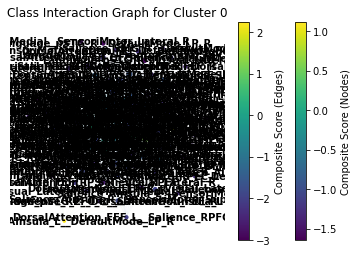

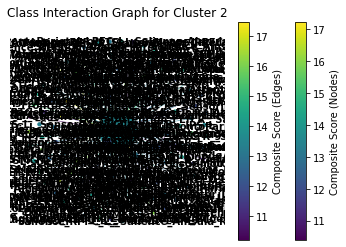

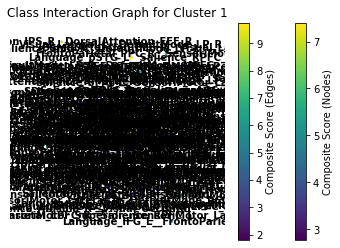

In [226]:
grapher = ClassInteractionAnalyzer(performance_df, predictor_to_class_dict)
grapher.run()

Assign predictors to classes and re-run

In [221]:
predictor_to_class_dict = {}
for pred in indep_var_list:
    base_name = re.split(r'_[LR]_', pred)[0]
    if pred not in predictor_to_class_dict.keys():
        predictor_to_class_dict[pred] = base_name

In [222]:
v = predictor_to_class_dict.values()
print(set(v))

{'DefaultMode_PCC__DefaultMode_LP_R', 'DorsalAttention_FEF', 'Visual_Occipital__DefaultMode_MPFC', 'Language_IFG', 'SensoriMotor_Superior__SensoriMotor_Lateral_R', 'FrontoParietal_PPC', 'SensoriMotor_Lateral', 'Visual_Occipital__Visual_Medial', 'Language_pSTG', 'Visual_Occipital__DefaultMode_LP_R', 'Salience_RPFC', 'impact_lab_prob', 'Visual_Lateral', 'Salience_SMG', 'Visual_Occipital__DefaultMode_LP_L', 'Salience_ACC__DefaultMode_LP_R', 'DefaultMode_LP', 'DorsalAttention_IPS', 'Visual_Medial__SensoriMotor_Lateral_R', 'FrontoParietal_LPFC', 'Salience_AInsula'}


/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/3051455907.py:345: DeprecationWarning:

`alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/3051455907.py:349: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_5467/3051455907.py:355: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



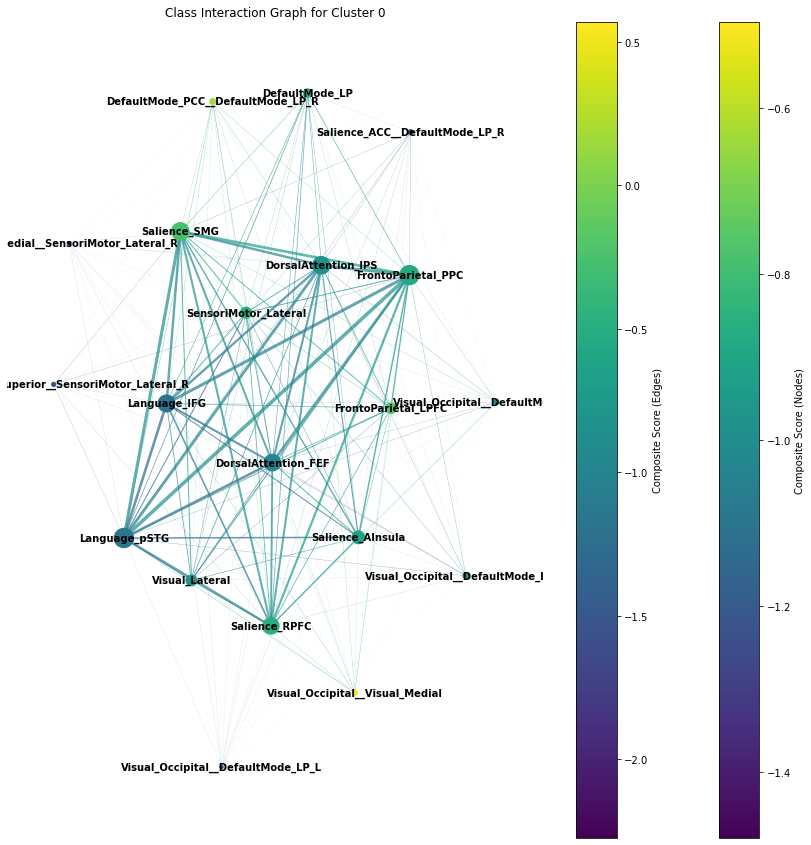

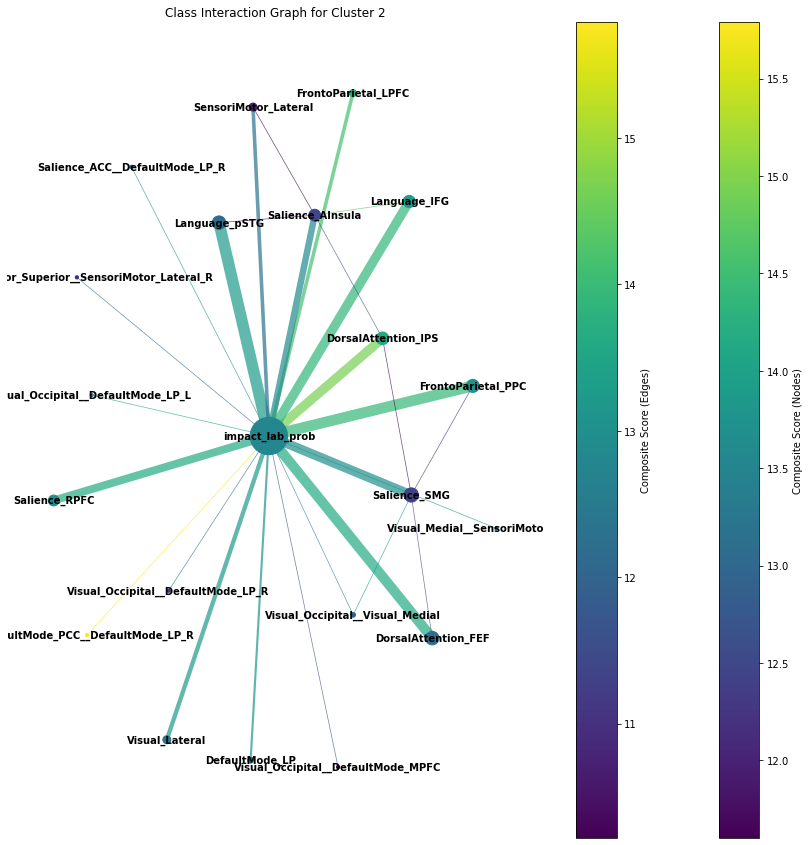

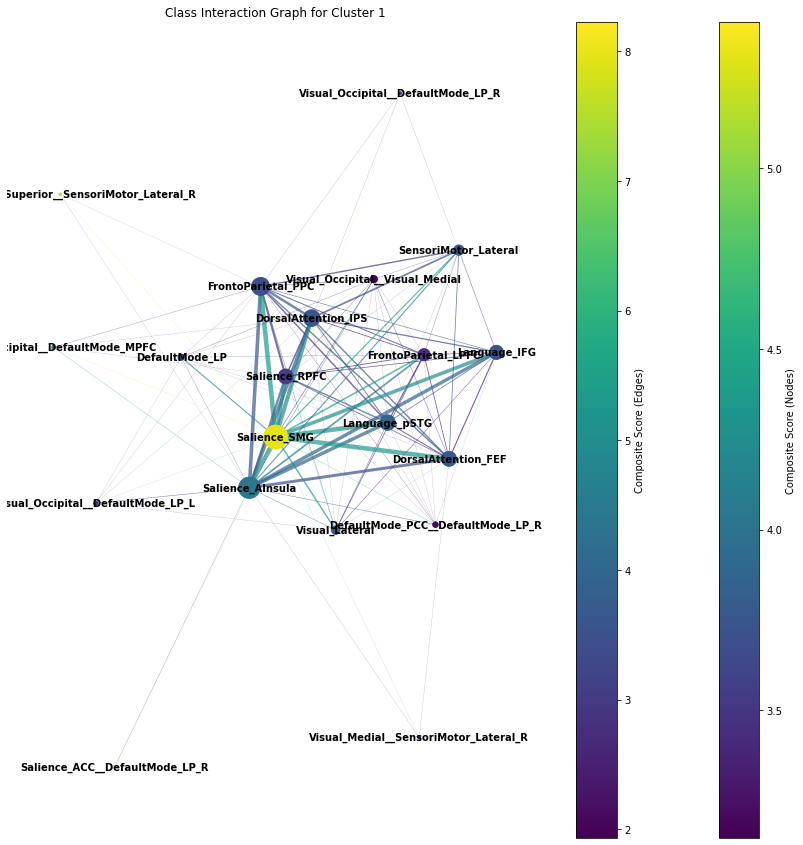

In [223]:
grapher = ClassInteractionAnalyzer(performance_df, predictor_to_class_dict)
grapher.run()

# Stable

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math
# size = count * 15

class InteractionVisualizer:
    
    def __init__(self, essential_data_df):
        """
        Initializes the InteractionVisualizer class.
        
        :param essential_data_df: Dataframe containing formula, r_squared, rmse, correlation, and Cluster_Label columns.
        """
        self.data = essential_data_df
        
    def compute_overall_interaction_counts(self, predictor_to_class_dict):
        """
        Computes the overall interaction counts between every pair of classes across the entire dataset.
        """
        interactions = defaultdict(int)
        for formula in self.data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    interactions[tuple(sorted([classes[i], classes[j]]))] += 1
        return interactions

    def extract_interactions_for_cluster(self, cluster_label, predictor_to_class_dict):
        """
        Extract interactions from the formula column of the dataframe for a specific cluster.
        Returns a dictionary with classes as keys and their normalized occurrence counts as values.
        """
        overall_counts = self.compute_overall_class_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_counts = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            for pred in predictors:
                pred_class = predictor_to_class_dict.get(pred, "Unknown")
                cluster_counts[pred_class] += 1

        # Normalize the counts by dividing by the overall counts
        normalized_counts = {k: v / overall_counts[k] for k, v in cluster_counts.items()}
        return normalized_counts

    def extract_normalized_interactions_for_cluster(self, cluster_label, predictor_to_class_dict):
        """
        Extract and normalize interaction counts for a specific cluster.
        """
        overall_interactions = self.compute_overall_interaction_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_interactions = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    cluster_interactions[tuple(sorted([classes[i], classes[j]]))] += 1

        # Normalize the interaction counts
        normalized_interactions = {k: v / overall_interactions[k] for k, v in cluster_interactions.items()}
        return normalized_interactions

    def map_interactions_to_classes(self, interaction_counts, predictor_to_class_dict):
        """
        Maps the interactions to their respective classes.
        
        :param interaction_counts: A dictionary containing predictors and their occurrence counts.
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        
        Returns a dictionary with classes as keys and the summed occurrence counts as values.
        """
        class_counts = defaultdict(int)
        for predictor, count in interaction_counts.items():
            predictor_class = predictor_to_class_dict.get(predictor, "Unknown")
            class_counts[predictor_class] += count
        return class_counts
    
    def visualize_class_interactions_for_cluster(self, cluster_label, predictor_to_class_dict, class_scaling_factor=15, interaction_scaling_factor=1):
        """
        Visualizes the interaction between classes for a specific cluster using a graph representation.
        
        :param cluster_label: The specific cluster label for which interactions are to be visualized.
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        :param class_scaling_factor: A scaling factor to adjust the node size.
        """
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        plt.figure(figsize=(12, 10))
        
        # Dictionary to store class-pair interactions
        class_pair_counts = defaultdict(int)
        
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            
            # Create pairs of predictors for each interaction in the formula
            for i in range(len(predictors)):
                for j in range(i+1, len(predictors)):
                    class1 = predictor_to_class_dict.get(predictors[i], "Unknown")
                    class2 = predictor_to_class_dict.get(predictors[j], "Unknown")
                    
                    # Sort class pair to ensure (class1, class2) and (class2, class1) are treated the same
                    class_pair = tuple(sorted([class1, class2]))
                    class_pair_counts[class_pair] += 1
                    
        G = nx.Graph()
        
        # Create nodes for each class
        all_classes = set(predictor_to_class_dict.values())
        for class_name in all_classes:
            size = sum([count for pair, count in class_pair_counts.items() if class_name in pair])
            size *= class_scaling_factor
            G.add_node(class_name, size=size)
            
        # Create edges between class nodes with weights proportional to their interaction count
        for (class1, class2), weight in class_pair_counts.items():
            G.add_edge(class1, class2, weight=weight)
            
        # Plot the graph
        # pos = nx.spring_layout(G)
        pos = nx.spring_layout(G, k=.95, iterations=100)
        sizes = [G.nodes[node]['size'] for node in G]
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="skyblue")
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        
        # Draw edges with weights
        for (u, v, d) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['weight'] * 0.05)  # Adjust the factor (0.05) as needed
        
        plt.title(f"Class Interaction Graph for Cluster {cluster_label}")
        plt.show()

    def visualize_all_clusters(self, predictor_to_class_dict, class_scaling_factor=15, interaction_scaling_factor=1):
        """
        Visualizes the class interactions for all unique clusters in the data using subplots.
        
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        """
        unique_clusters = self.data['Cluster_Label'].unique()

        for cluster_label in unique_clusters:
            plt.figure()
            self.visualize_class_interactions_for_cluster(cluster_label, predictor_to_class_dict, class_scaling_factor, interaction_scaling_factor)
